## Add path to source files

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.path.abspath('..'), 'src'))

## If not already created, make save folder for figures

In [2]:
save_folder = r'two-disclination-simulation-figures'
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

## Import necessary packages, add loading bars, make plots big

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import FiniteDifference as fd
import LiquidCrystalHelper as lch

from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt

import time
from importlib import reload

In [4]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Video
from IPython.display import Image

In [5]:
reload(lch)

<module 'LiquidCrystalHelper' from 'C:\\Users\\lucas\\Documents\\Grad Work\\Summer Research 2020\\LiquidCrystalHydrodynamics\\src\\LiquidCrystalHelper.py'>

In [6]:
%matplotlib inline
dpi = 700
mpl.rcParams['figure.dpi'] = dpi

## Begin with a $300\times 300$ grid, with one $+1/2$ disclination and one $-1/2$ disclination

### Set up domain

In [7]:
l = 10
n = 300

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

### Create two disclinations, get auxiliary variables

In [8]:
S_val = 0.5
ctr = [[-2, 0], [2, 0]]
r = [1, 1]
m = [-1/2, 1/2]

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

### Get initial eigenvalues/vectors, plot configuration

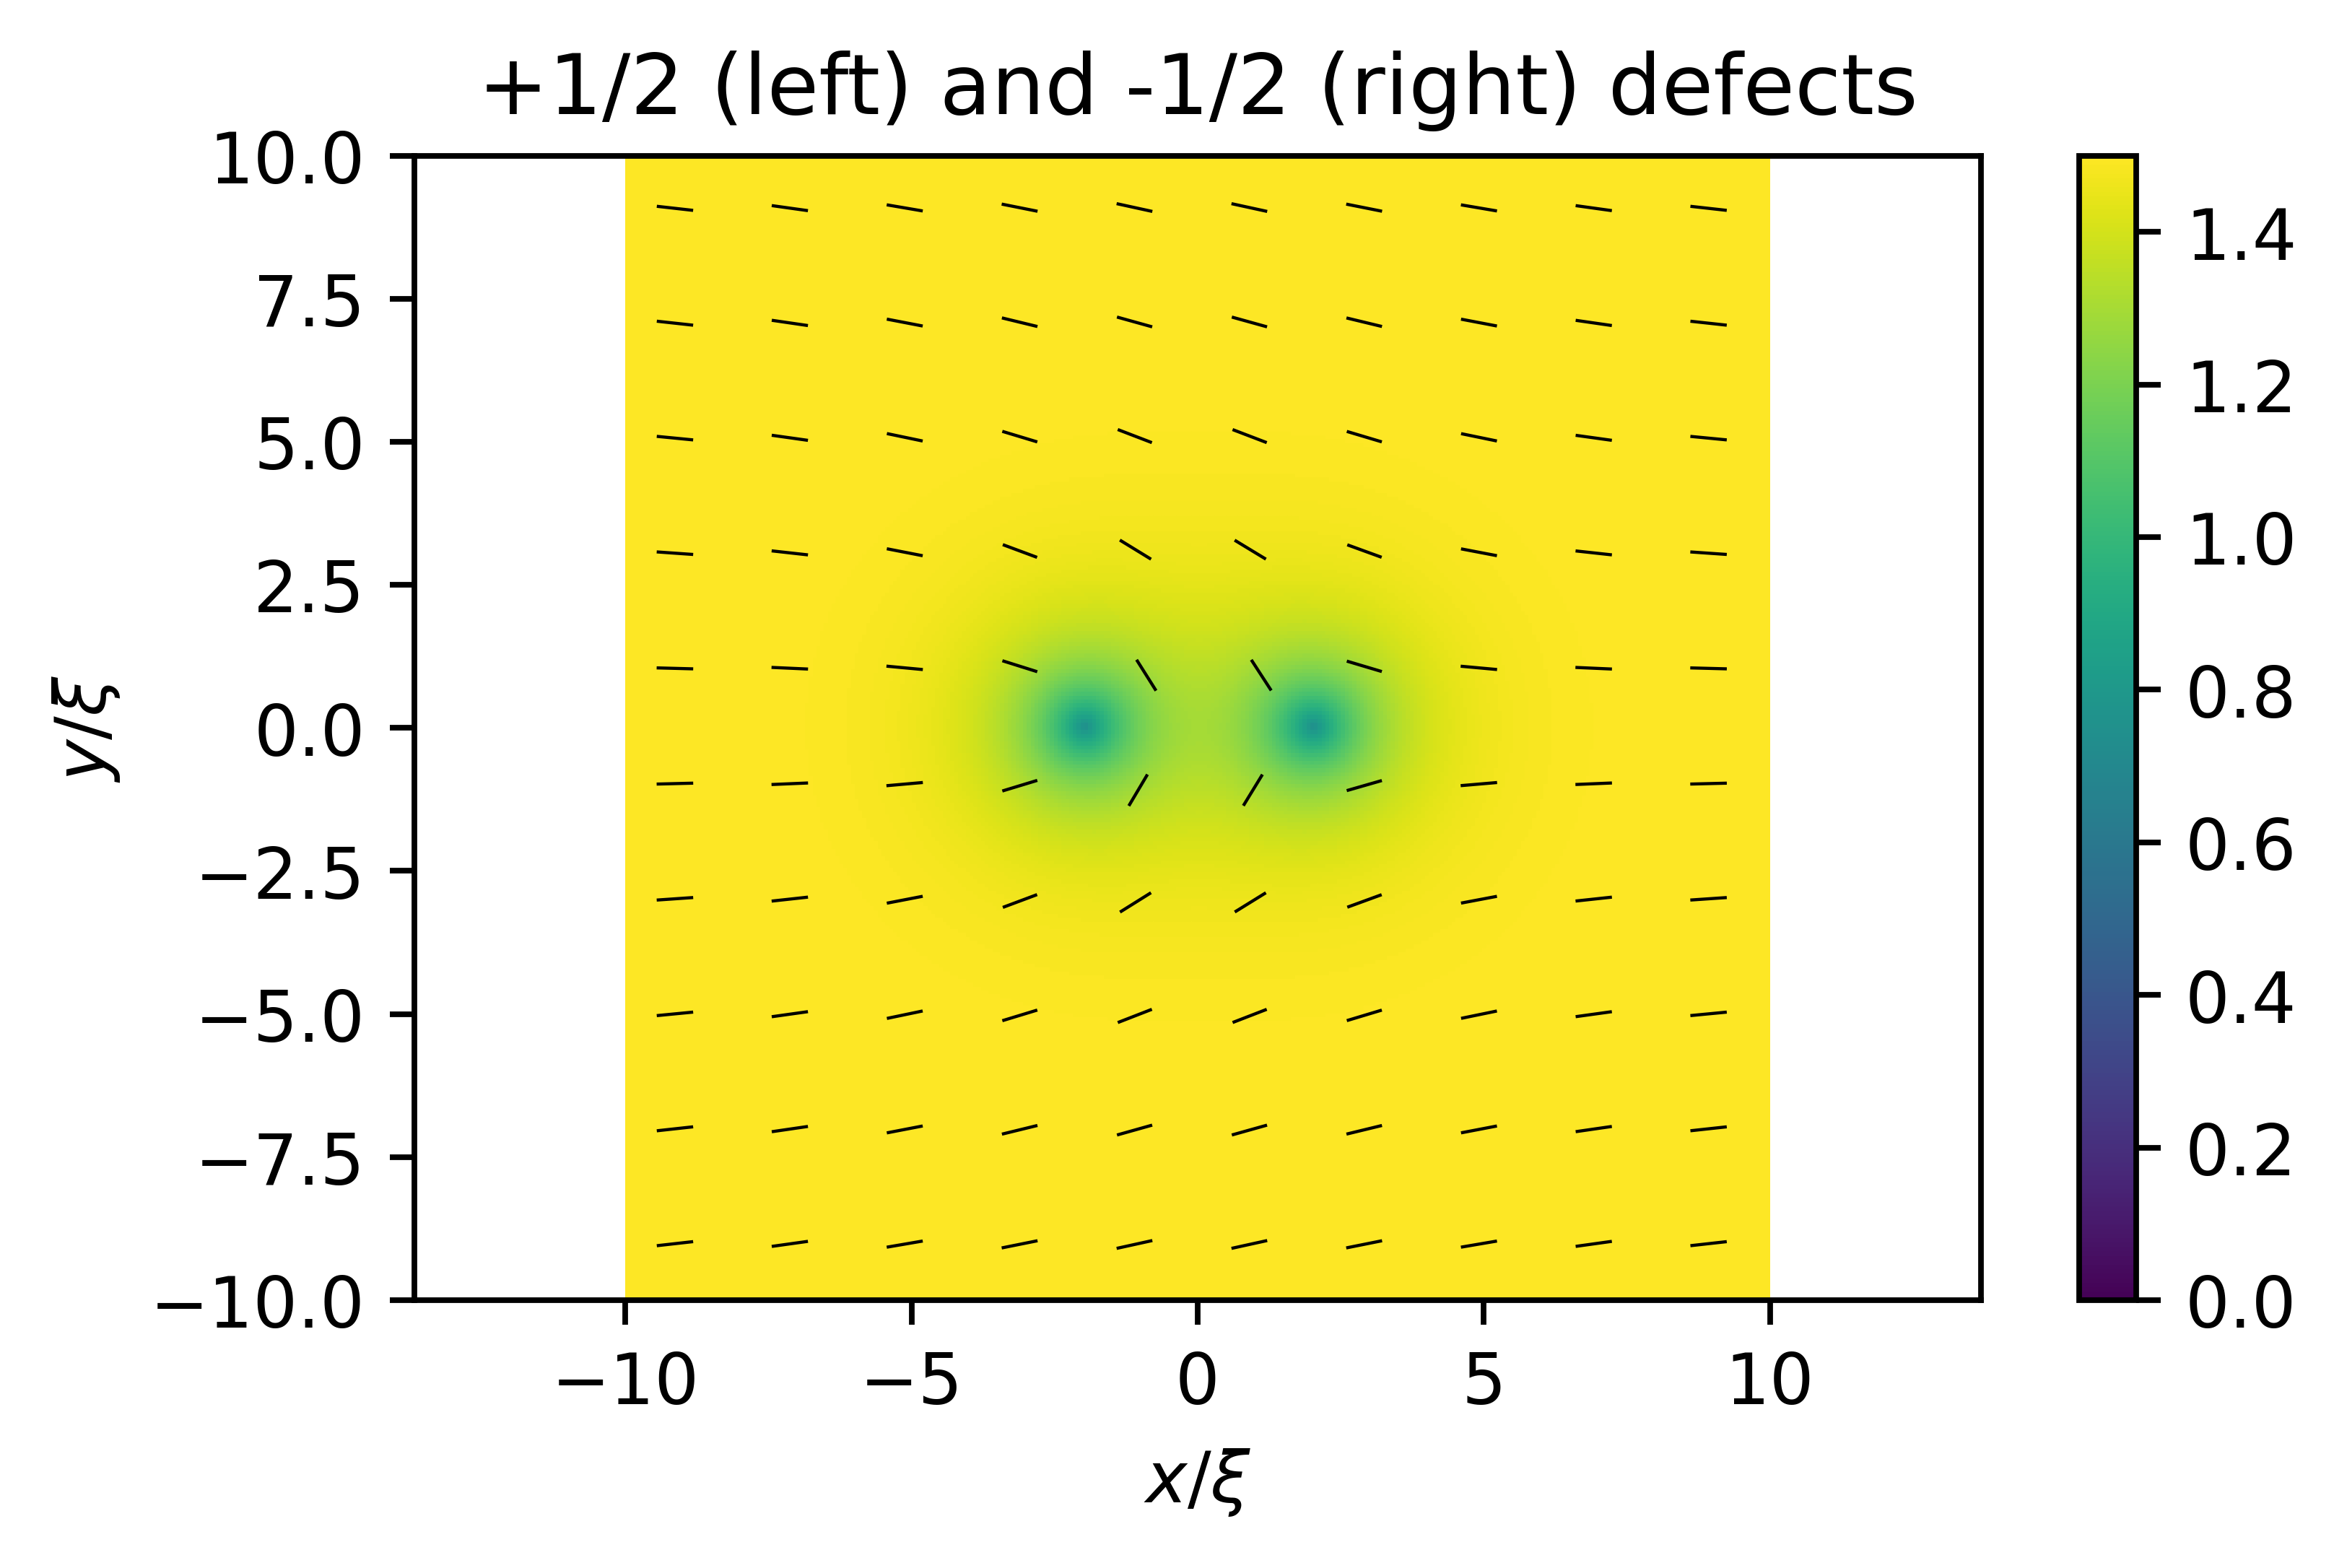

In [9]:
sparse_shape = (10, 10)
S_sparse_shape = (200, 200)
S_cutoff = 0.3

lambda_max = lch.calcQEigenvals(eta, mu, nu)
U, V = lch.calcQEigenvecs(eta, mu, nu, lambda_max, S_cutoff)

sparse_idx = lch.sparseIdx(Q[0, 0].shape, sparse_shape)
S_sparse_idx = lch.sparseIdx(Q[0, 0].shape, S_sparse_shape)

fig, ax = plt.subplots(figsize=(5, 3))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx], (3/2)*lambda_max[S_sparse_idx], vmin=0, vmax=1.5)
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)

ax.axis('equal')
fig.colorbar(c, ax=ax)
ax.set_title("+1/2 (left) and -1/2 (right) defects")
ax.set_xlabel(r"$x/\xi$")
ax.set_ylabel(r"$y/\xi$")

filenamet0 = os.path.join(save_folder, r'two-disclinations-t0-config.png')
fig.savefig(filenamet0)

### Find peaks of $y = \text{const.}$ slice through middle, plot where peaks are found

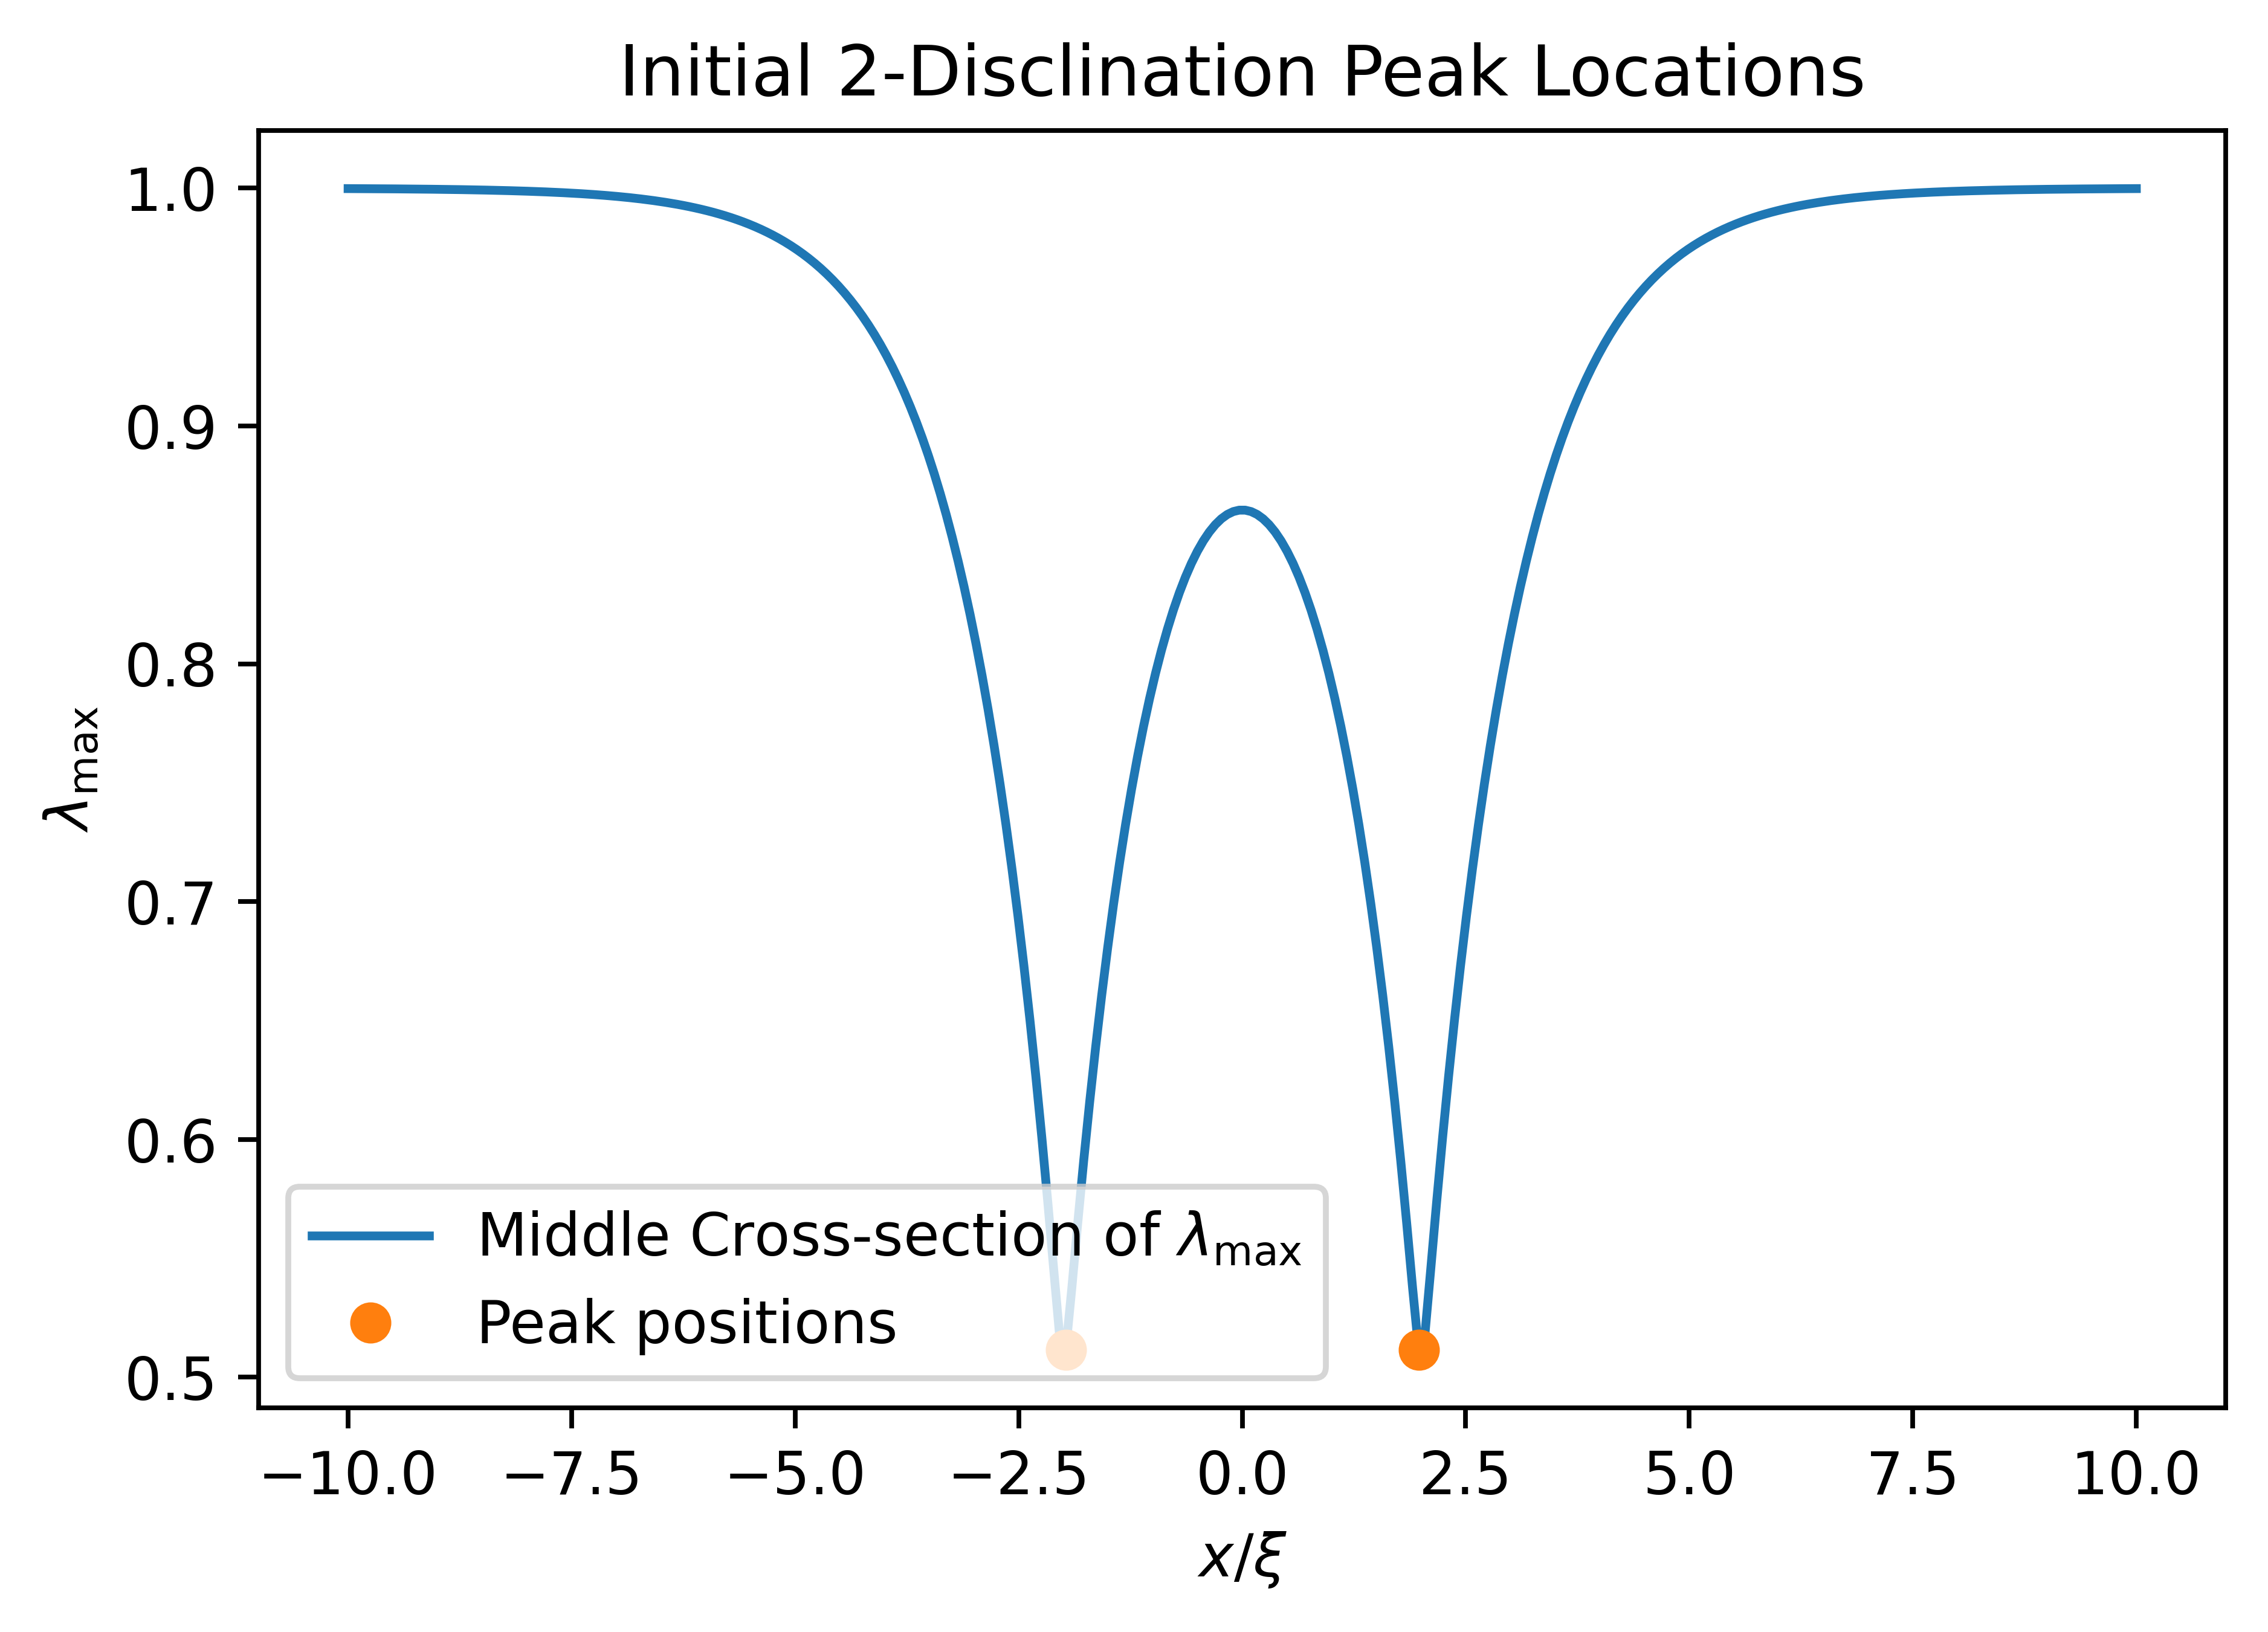

In [10]:
middle = np.floor(n/2).astype('int')
peaks, _ = find_peaks(-lambda_max[:, middle])

plt.plot(X[:, middle], lambda_max[:, middle], label=r'Middle Cross-section of $\lambda_\mathrm{max}$')
plt.plot(X[peaks, middle], lambda_max[peaks, middle], marker='o', ls='', label='Peak positions')

plt.legend()
plt.title('Initial 2-Disclination Peak Locations')
plt.ylabel(r'$\lambda_\mathrm{max}$')
plt.xlabel(r'$x/\xi$')

filename_crosssection_peaks = os.path.join(save_folder, r'two-disclination-cross-section-peak-locations.png')
plt.savefig(filename_crosssection_peaks)

### Do a forward euler scheme with `dt` step size and `num_steps` number of steps

In [11]:
dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/4
num_steps = 5000
t = np.zeros(num_steps)

expected_peak_num = 2
peak_pos = np.zeros((expected_peak_num, num_steps))
middle_slice = np.zeros((n, num_steps))

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

for i in range(num_steps):
    
    t[i] = i*dt
    
    eta_new = fd.forwardEuler(eta_old, dt, lch.etaEOM, mu_old, nu_old, dx, dy)
    mu_new = fd.forwardEuler(mu_old, dt, lch.muEOM, eta_old, nu_old, dx, dy)
    nu_new = fd.forwardEuler(nu_old, dt, lch.nuEOM, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    middle_slice[:, i] = lambda_max[:, middle]
    peaks, _ = find_peaks(-lambda_max[:, middle])
    if peaks.shape[0] <= 2:
        peak_pos[:, i] = X[peaks, middle]
    else:
        break
    
    # Update loading bar
    progress.value = i

# Truncate arrays if loop stops early
t = t[:i]
peak_pos = peak_pos[:, :i]

IntProgress(value=0, max=5000)

### Make animation **Warning**: next two cells take a long time to run

In [1]:
S_val = 1

fig, ax = plt.subplots()
xdata, ydata = X[:, middle], middle_slice[:, 0]
ln, = plt.plot(xdata, ydata)
plt.title(r"$\lambda_\mathrm{max}$ vs. $x/\xi$ for a $y = \mathrm{Const.}$ slice through middle")
plt.xlabel(r"$x/\xi$")
plt.ylabel(r"$\lambda_\mathrm{max}$")

def init(l=l, S_val=S_val):
    ax.set_xlim(-l, l)
    ax.set_ylim(0, S_val)
    return ln,

def update(frame, X=X, middle_slice=middle_slice, middle=middle):
    xdata = X[:, middle]
    ydata = middle_slice[:, frame]
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(0, i),
                    init_func=init, interval=2, blit=True)
plt.show()

NameError: name 'plt' is not defined

In [13]:
filename_300pt_crosssection_animation = os.path.join(save_folder, r'two-disclination-300pt-crosssection.mp4')
ani.save(filename_300pt_crosssection_animation, dpi=200)

### Results from animating and plotting

In [14]:
Video(filename_300pt_crosssection_animation, width=900)

### Plot defect positions vs. time

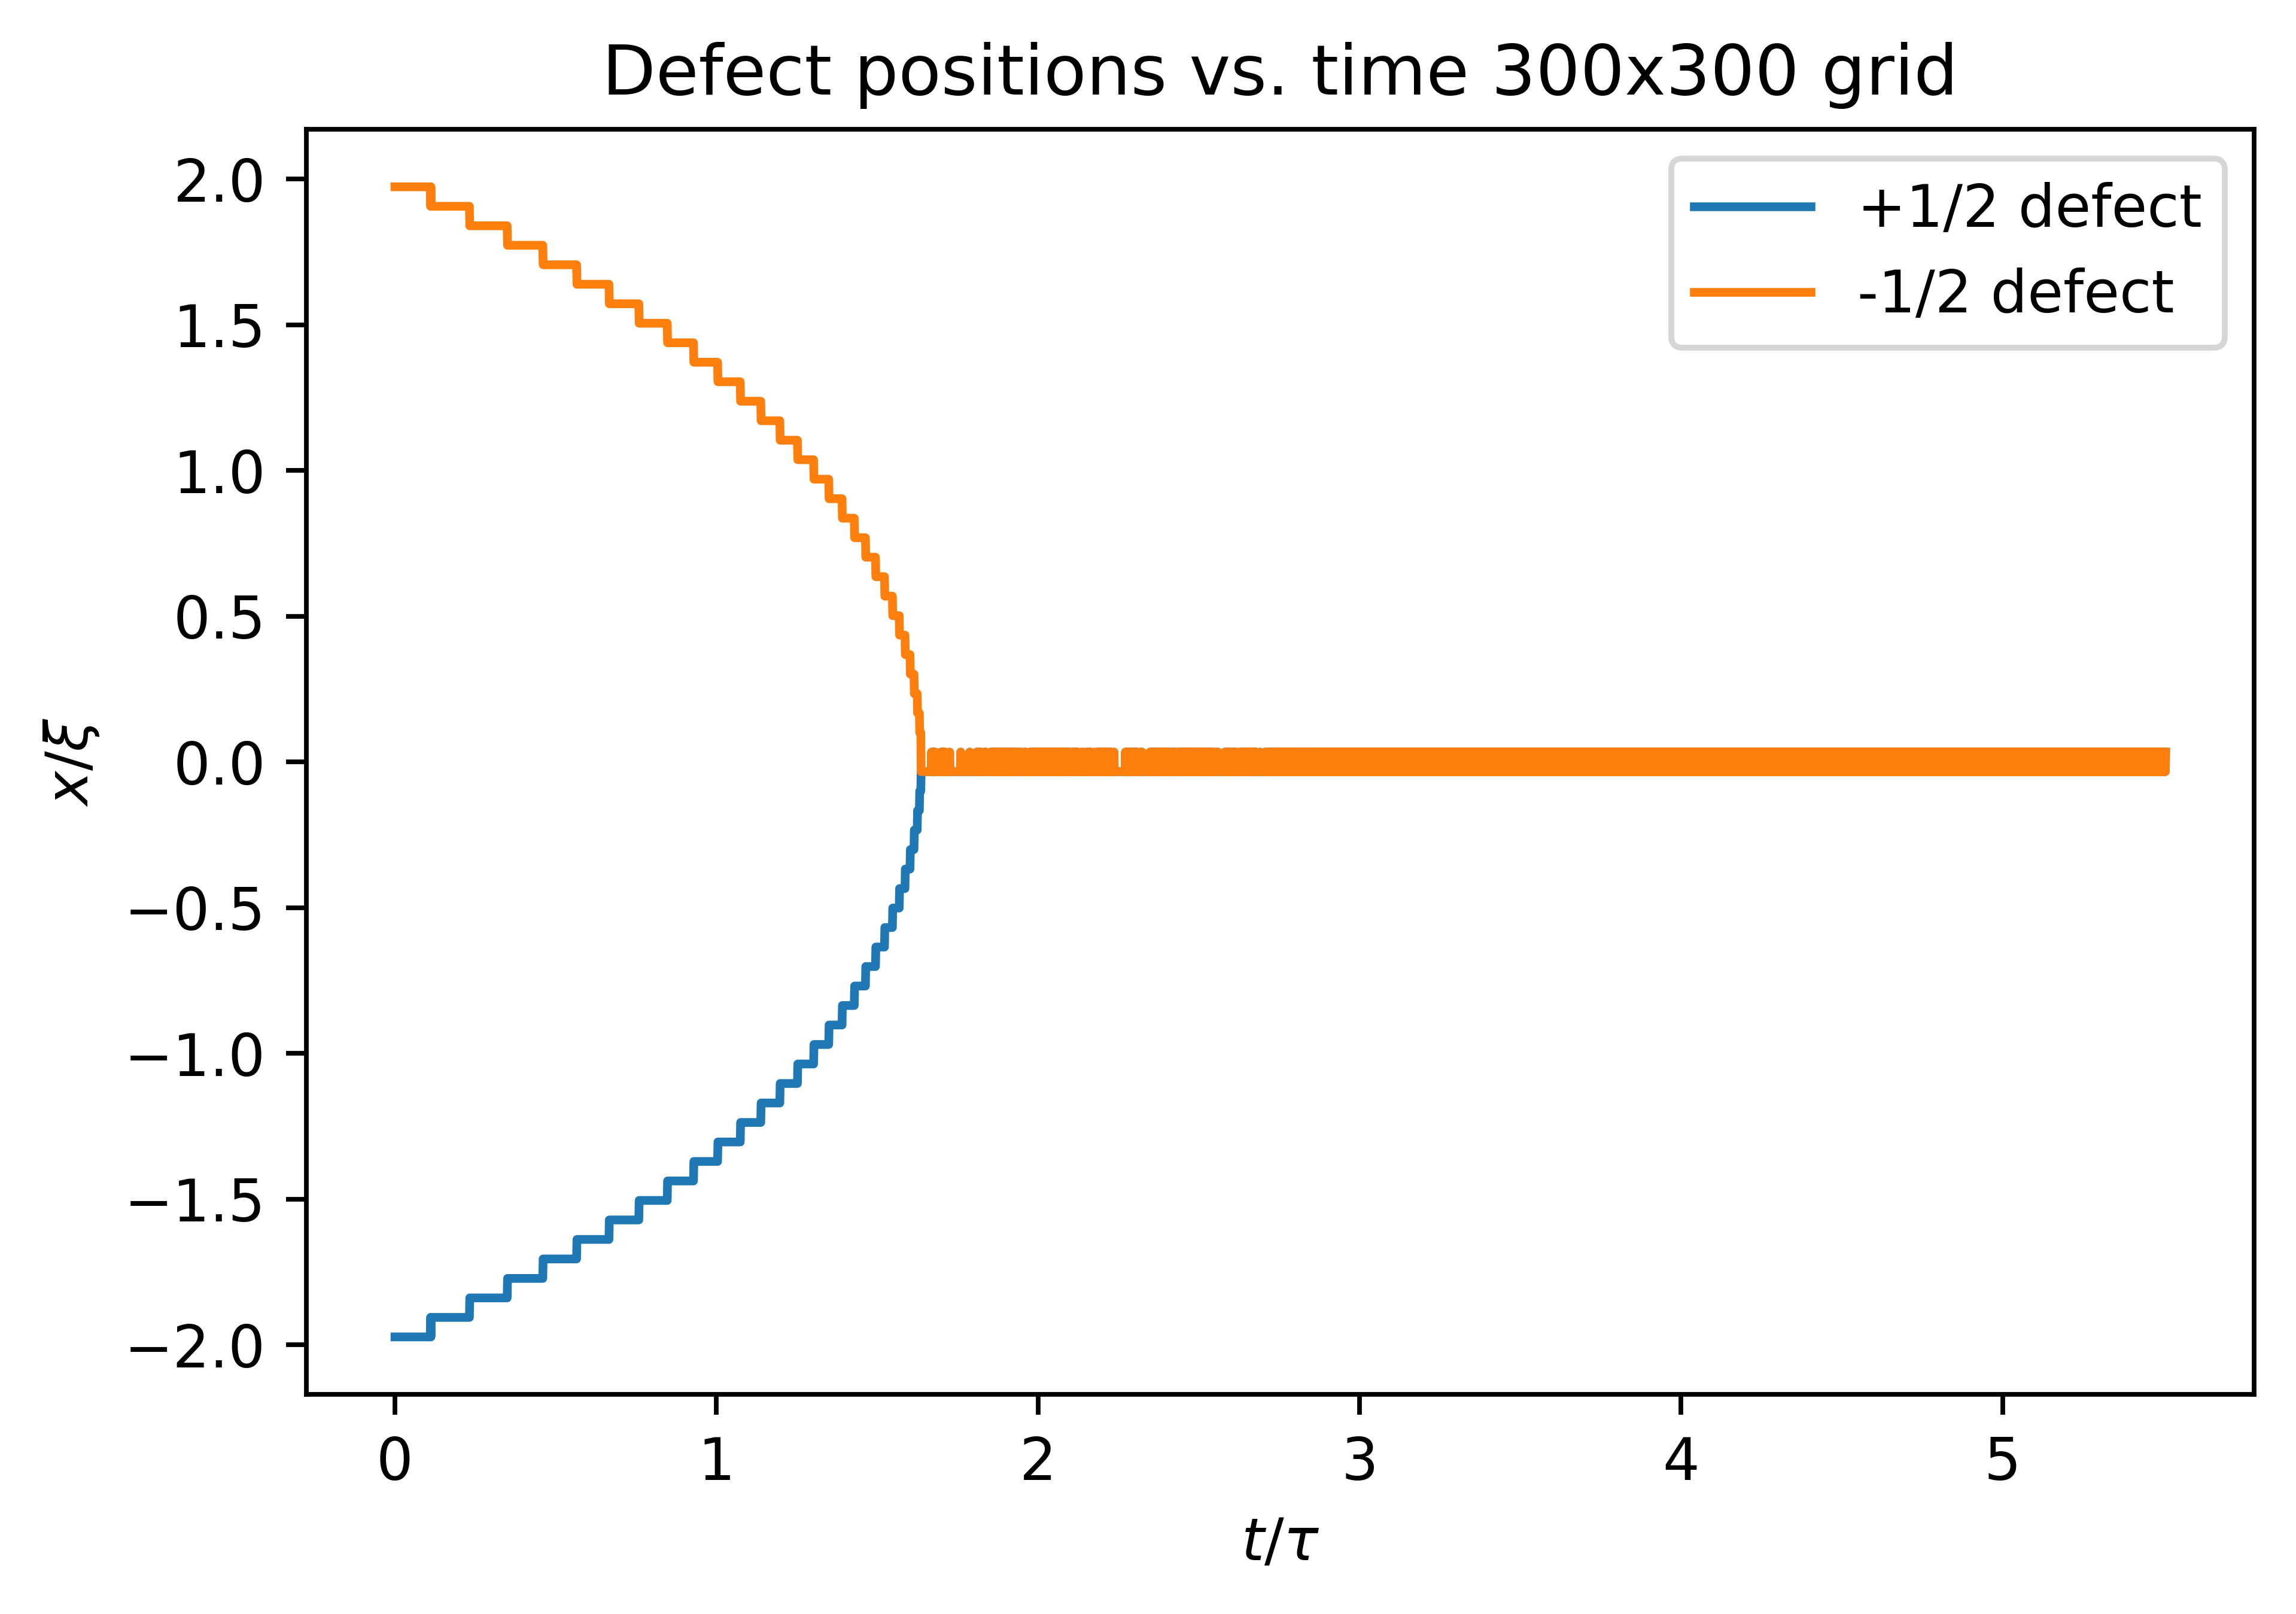

In [15]:
plt.plot(t, peak_pos[0, :], label="+1/2 defect")
plt.plot(t, peak_pos[1, :], label="-1/2 defect")
plt.title("Defect positions vs. time 300x300 grid")
plt.xlabel(r"$t/\tau$")
plt.ylabel(r"$x/\xi$")
plt.legend()

filename_defect_posvstime_300pts = os.path.join(save_folder, r'defect-pos-vs-time-300pts.png')
plt.savefig(filename_defect_posvstime_300pts)

-------

## Let's try the simulation with a $600\times 600$ point grid to see if it gets smoothed out

### Make domain, get auxiliary variables

In [16]:
l = 10
n = 600

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

S_val = 0.5
ctr = [[-2, 0], [2, 0]]
r = [1, 1]
m = [-1/2, 1/2]

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

### Get initial eigenvectors/values, make initial configuration plot

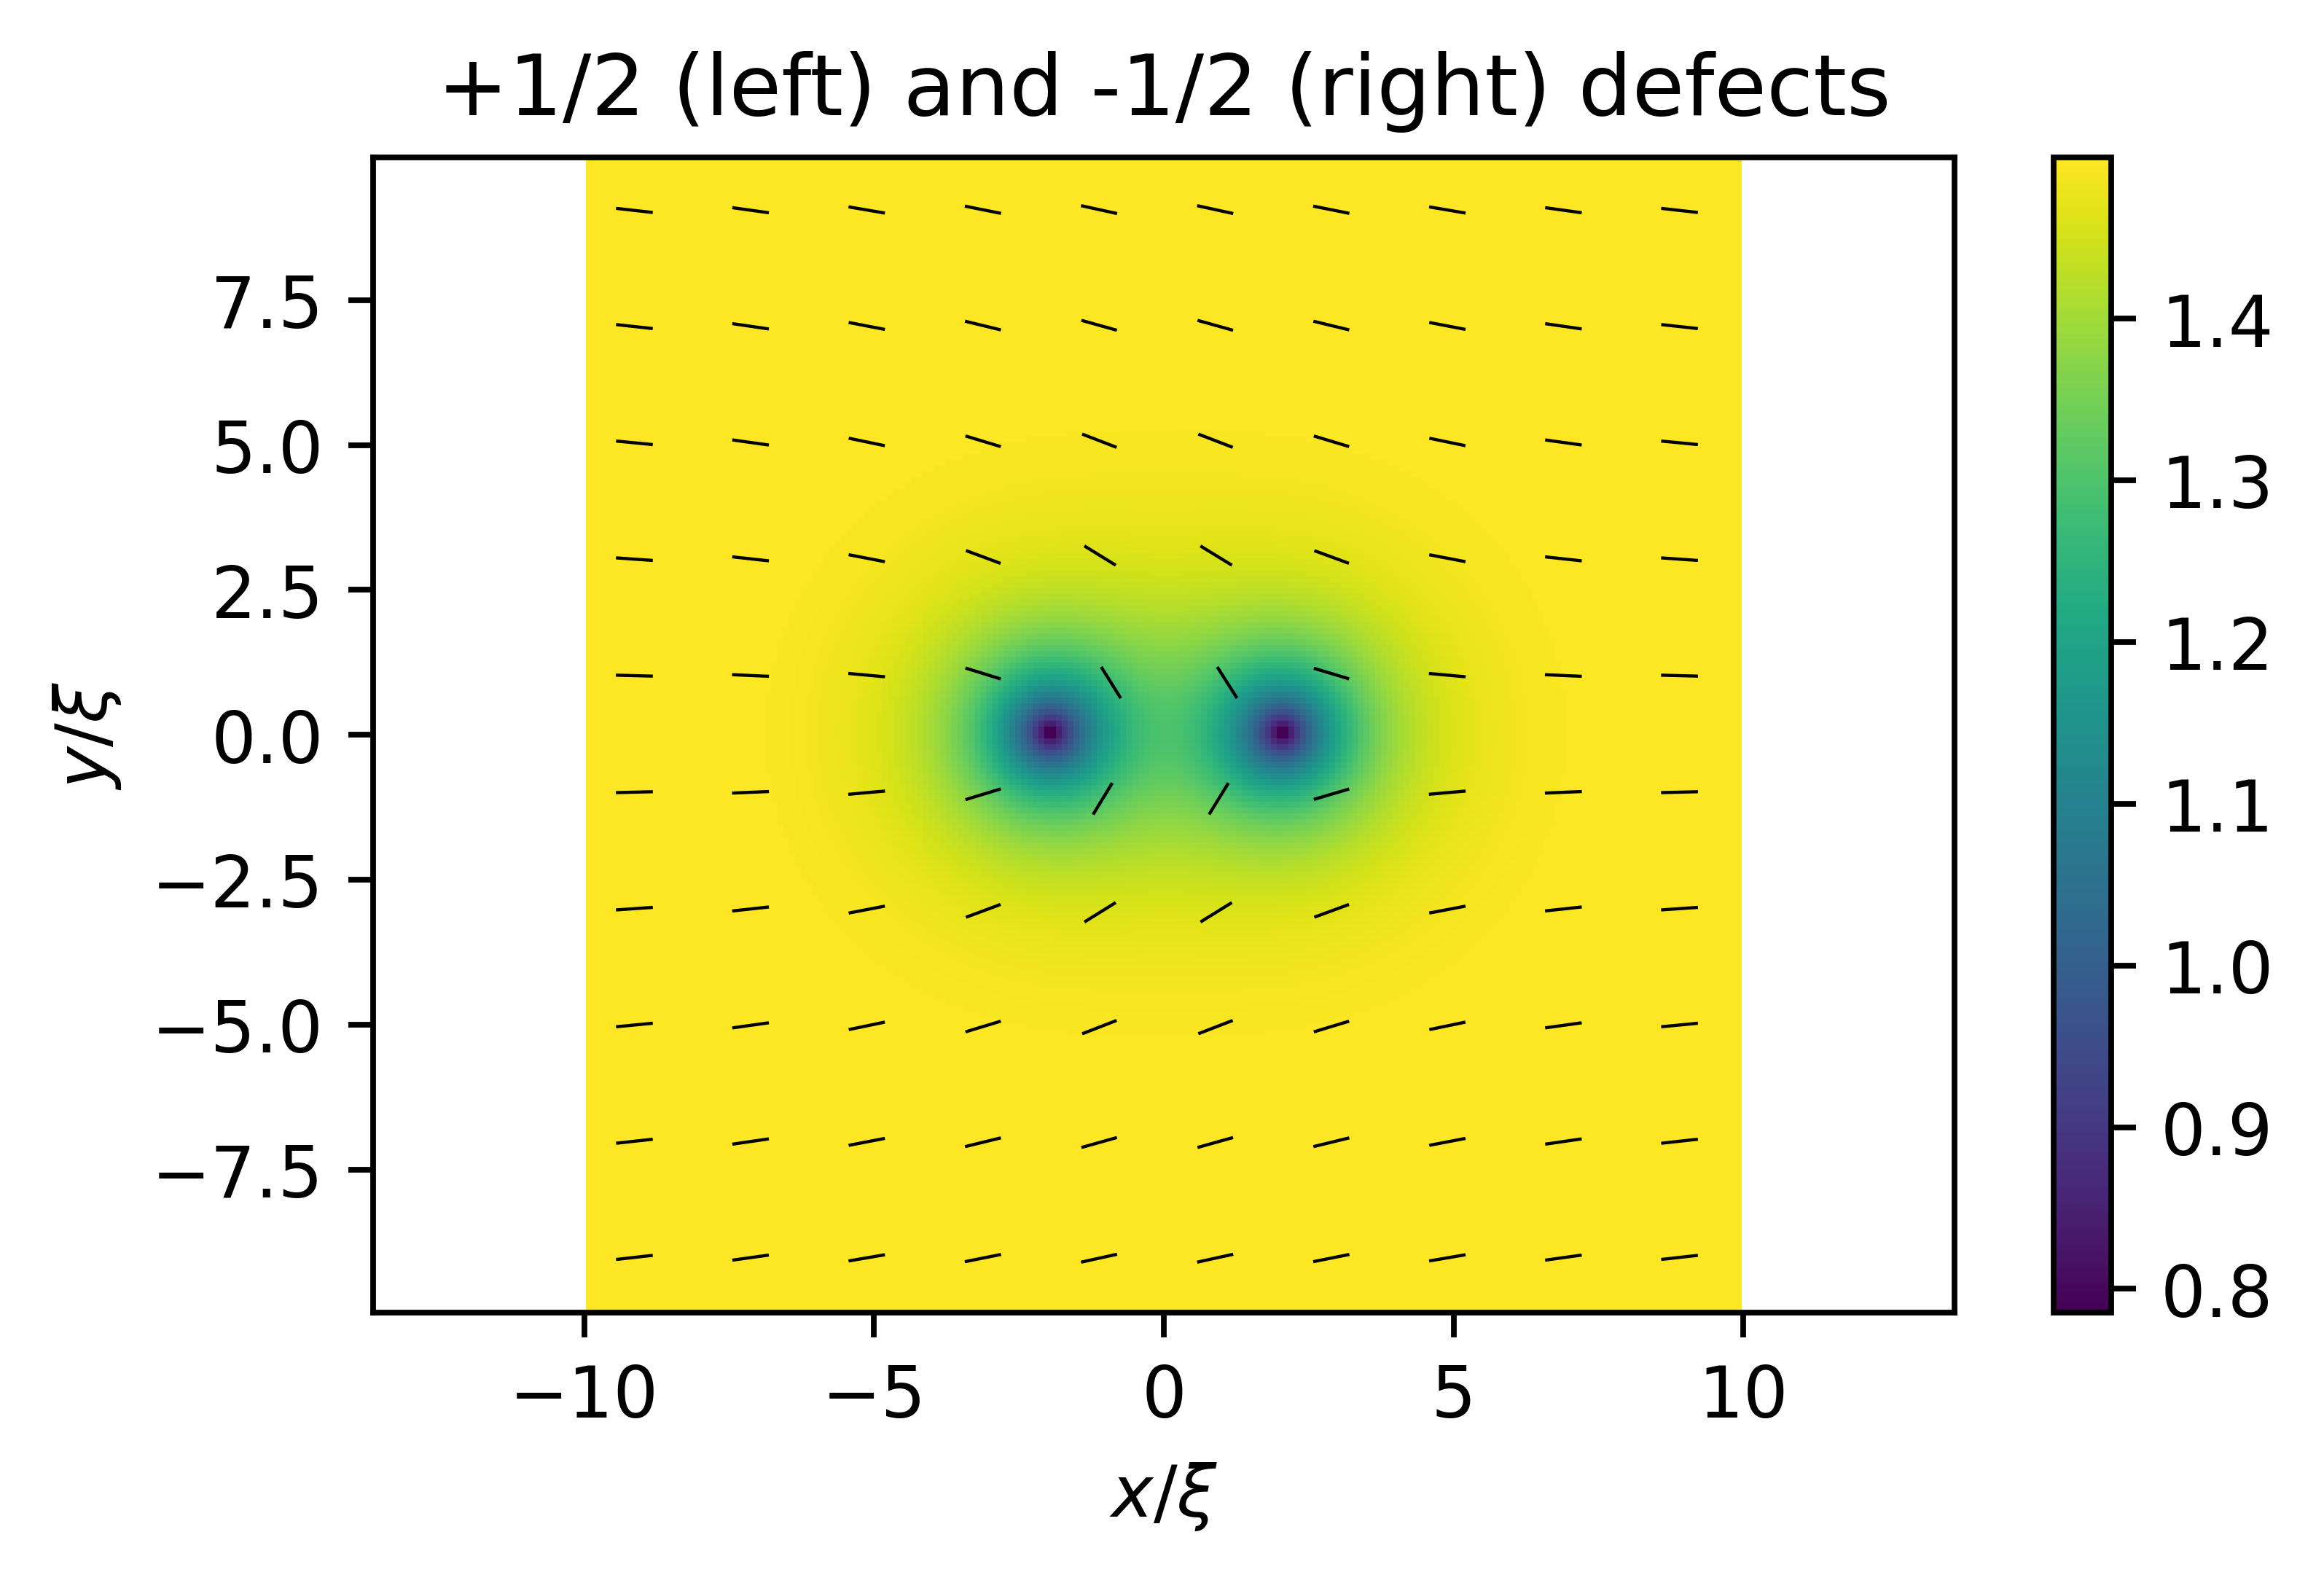

In [17]:
sparse_shape = (10, 10)
S_sparse_shape = (200, 200)
S_cutoff = 0.3

lambda_max = lch.calcQEigenvals(eta, mu, nu)
U, V = lch.calcQEigenvecs(eta, mu, nu, lambda_max, S_cutoff)

sparse_idx = lch.sparseIdx(Q[0, 0].shape, sparse_shape)
S_sparse_idx = lch.sparseIdx(Q[0, 0].shape, S_sparse_shape)

fig, ax = plt.subplots(figsize=(5, 3))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx], (3/2)*lambda_max[S_sparse_idx])
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)

ax.axis('equal')
fig.colorbar(c, ax=ax)
ax.set_title("+1/2 (left) and -1/2 (right) defects")
ax.set_xlabel(r"$x/\xi$")
ax.set_ylabel(r"$y/\xi$")

filenamet0_600pt = os.path.join(save_folder, r'two-disclinations-t0-600pt-config.png')
fig.savefig(filenamet0_600pt)

### Run forward euler method with step size `dt` and `num_steps` steps

In [18]:
dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/4
num_steps = 10000
peak_pos = np.zeros((2, num_steps))
t = np.zeros(num_steps)

middle = np.floor(n/2).astype('int')
middle_slice = np.zeros((n, num_steps))

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

start_time = time.perf_counter()
for i in range(num_steps):
    
    t[i] = i*dt
    
    eta_new = fd.forwardEuler(eta_old, dt, lch.etaEOM, mu_old, nu_old, dx, dy)
    mu_new = fd.forwardEuler(mu_old, dt, lch.muEOM, eta_old, nu_old, dx, dy)
    nu_new = fd.forwardEuler(nu_old, dt, lch.nuEOM, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks, _ = find_peaks(-lambda_max[:, middle])
    middle_slice[:, i] = lambda_max[:, middle]
    if peaks.shape[0] <= 2:
        peak_pos[:, i] = X[peaks, middle]
    else:
        break
    
    # Update loading bar
    progress.value = i
    
# Truncate arrays if loop stops early
t = t[:i]
peak_pos = peak_pos[:, :i]
    
end_time = time.perf_counter()
print("Total time elapsed is", (end_time - start_time)/60, "minutes")

IntProgress(value=0, max=10000)

KeyboardInterrupt: 

### Plot defect positions vs. time for $600\times 600$ grid

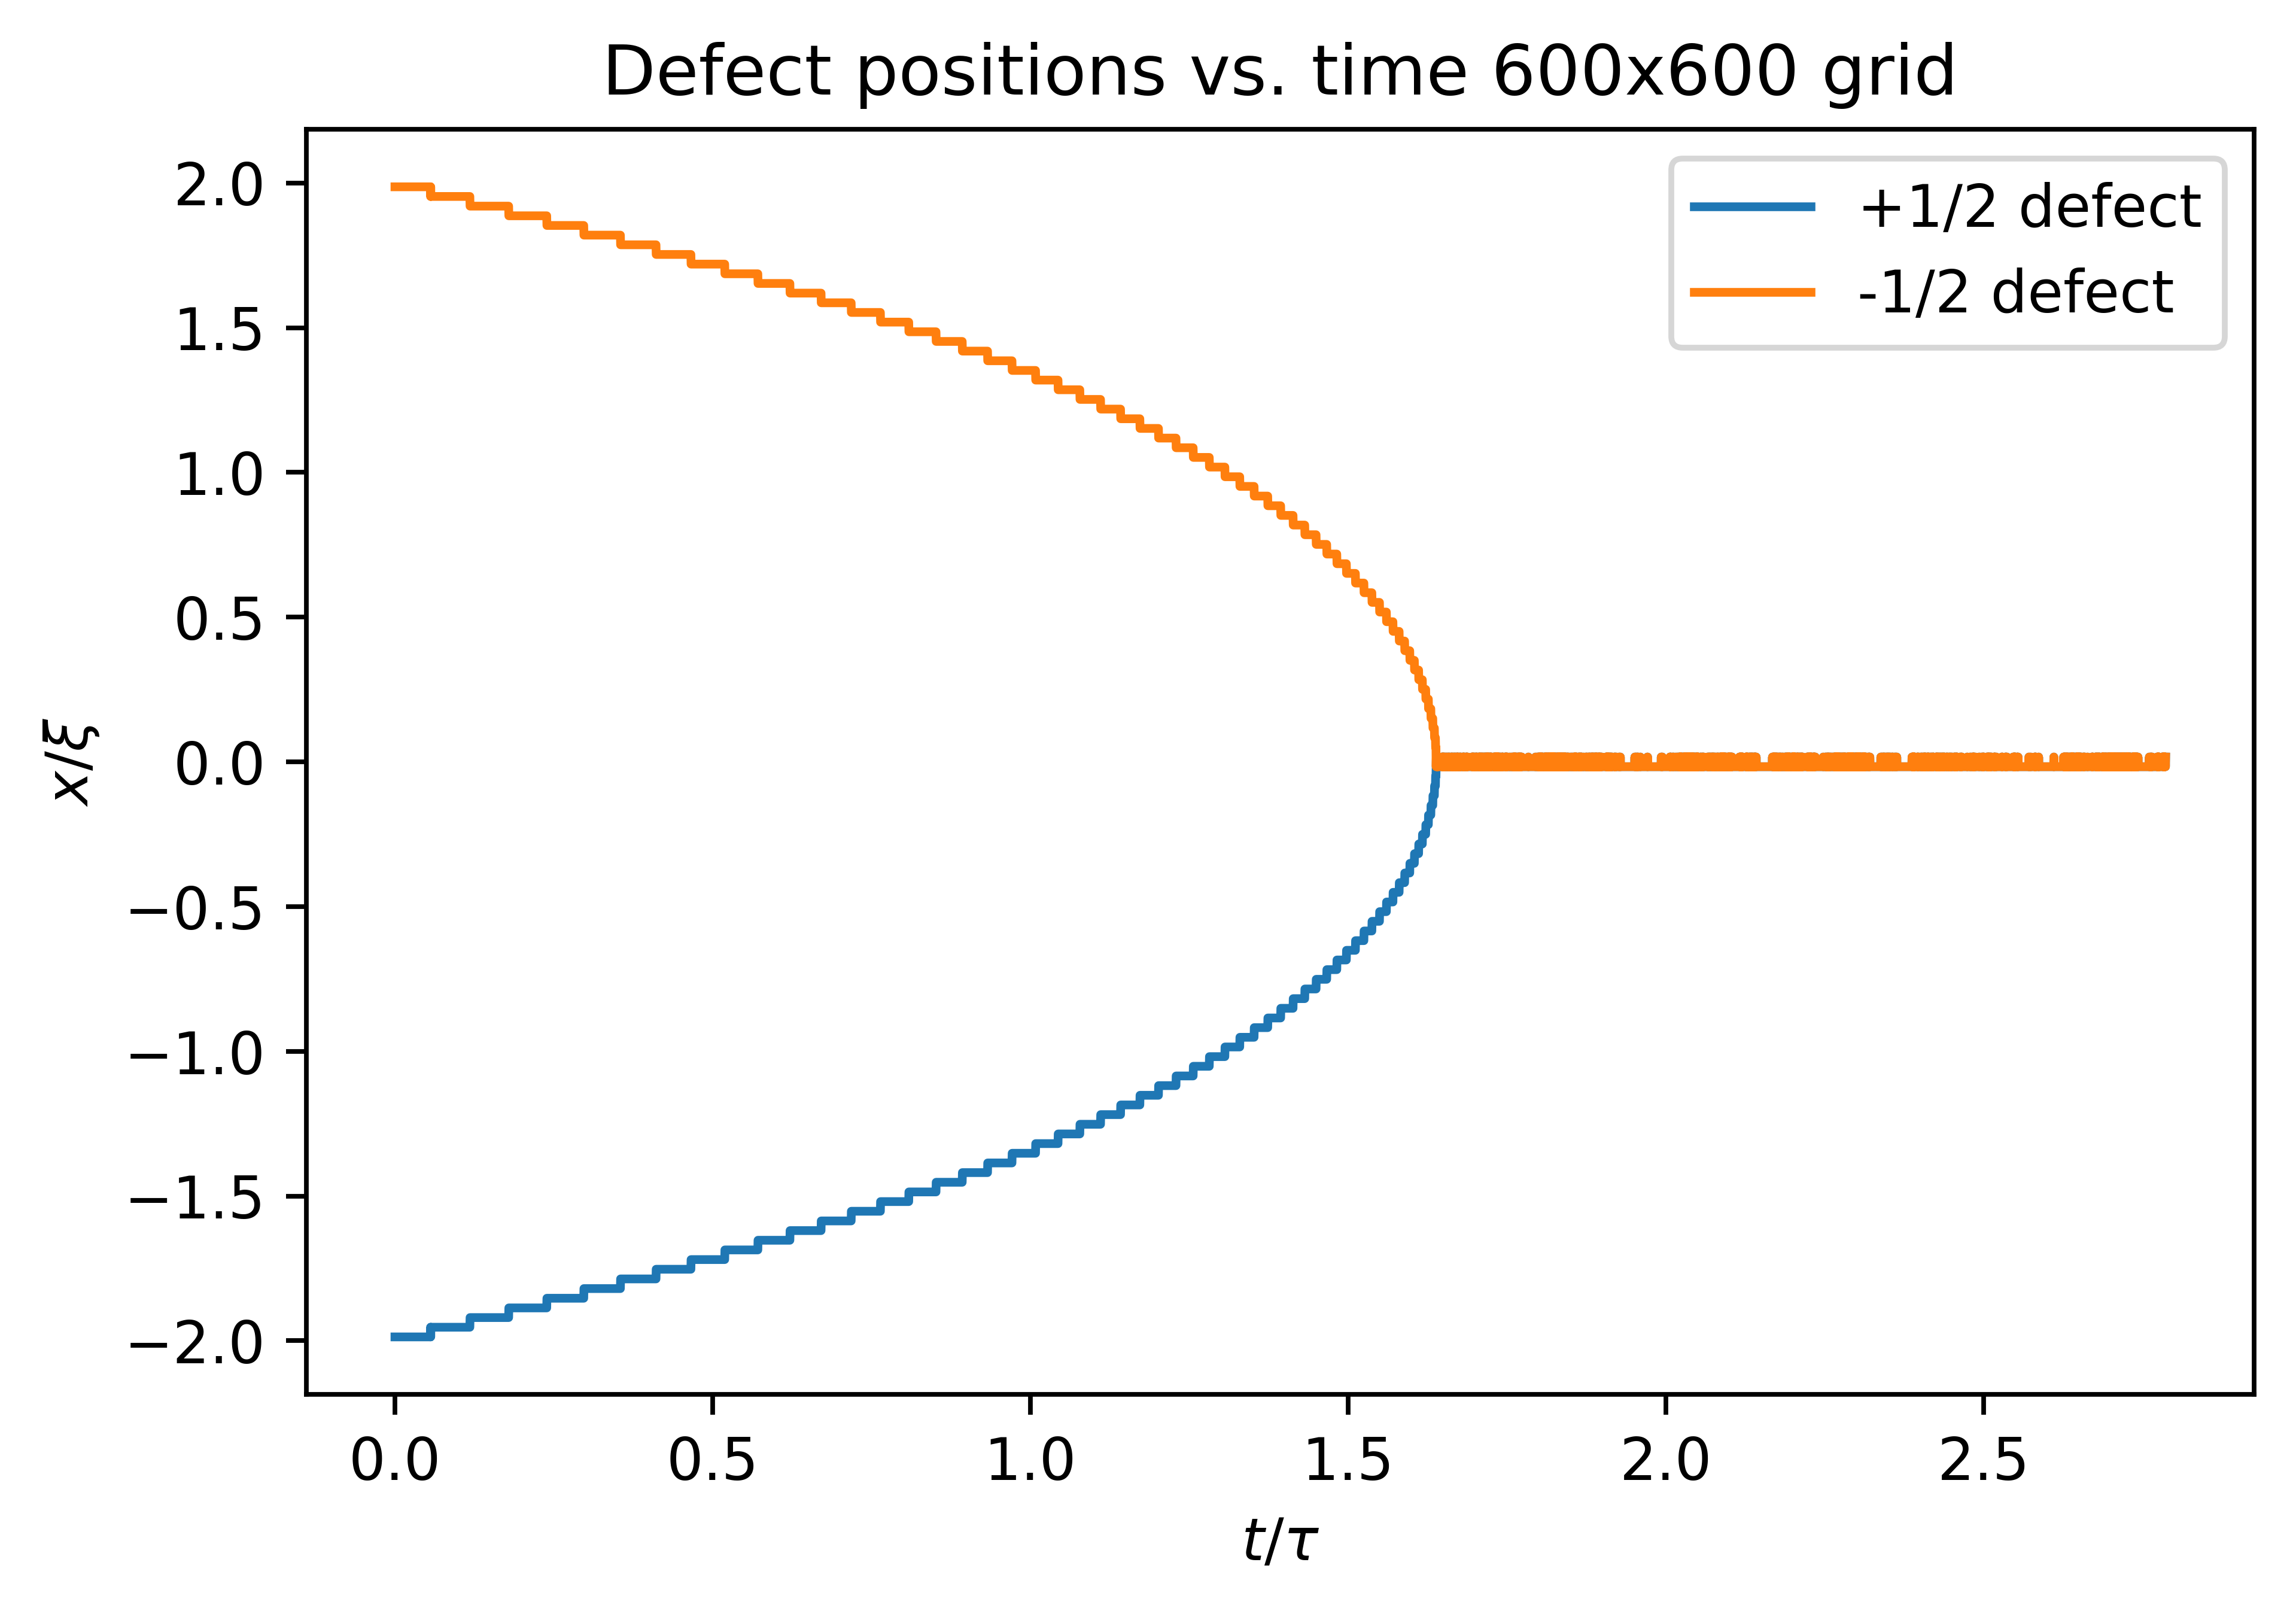

In [59]:
plt.plot(t, peak_pos[0, :], label="+1/2 defect")
plt.plot(t, peak_pos[1, :], label="-1/2 defect")
plt.title("Defect positions vs. time 600x600 grid")
plt.xlabel(r"$t/\tau$")
plt.ylabel(r"$x/\xi$")
plt.legend()

filename_defect_posvstime_600pts = os.path.join(save_folder, r'defect-pos-vs-time-600pts.png')
plt.savefig(filename_defect_posvstime_600pts)

### Make middle cross-section animation **Warning**: this takes a long time

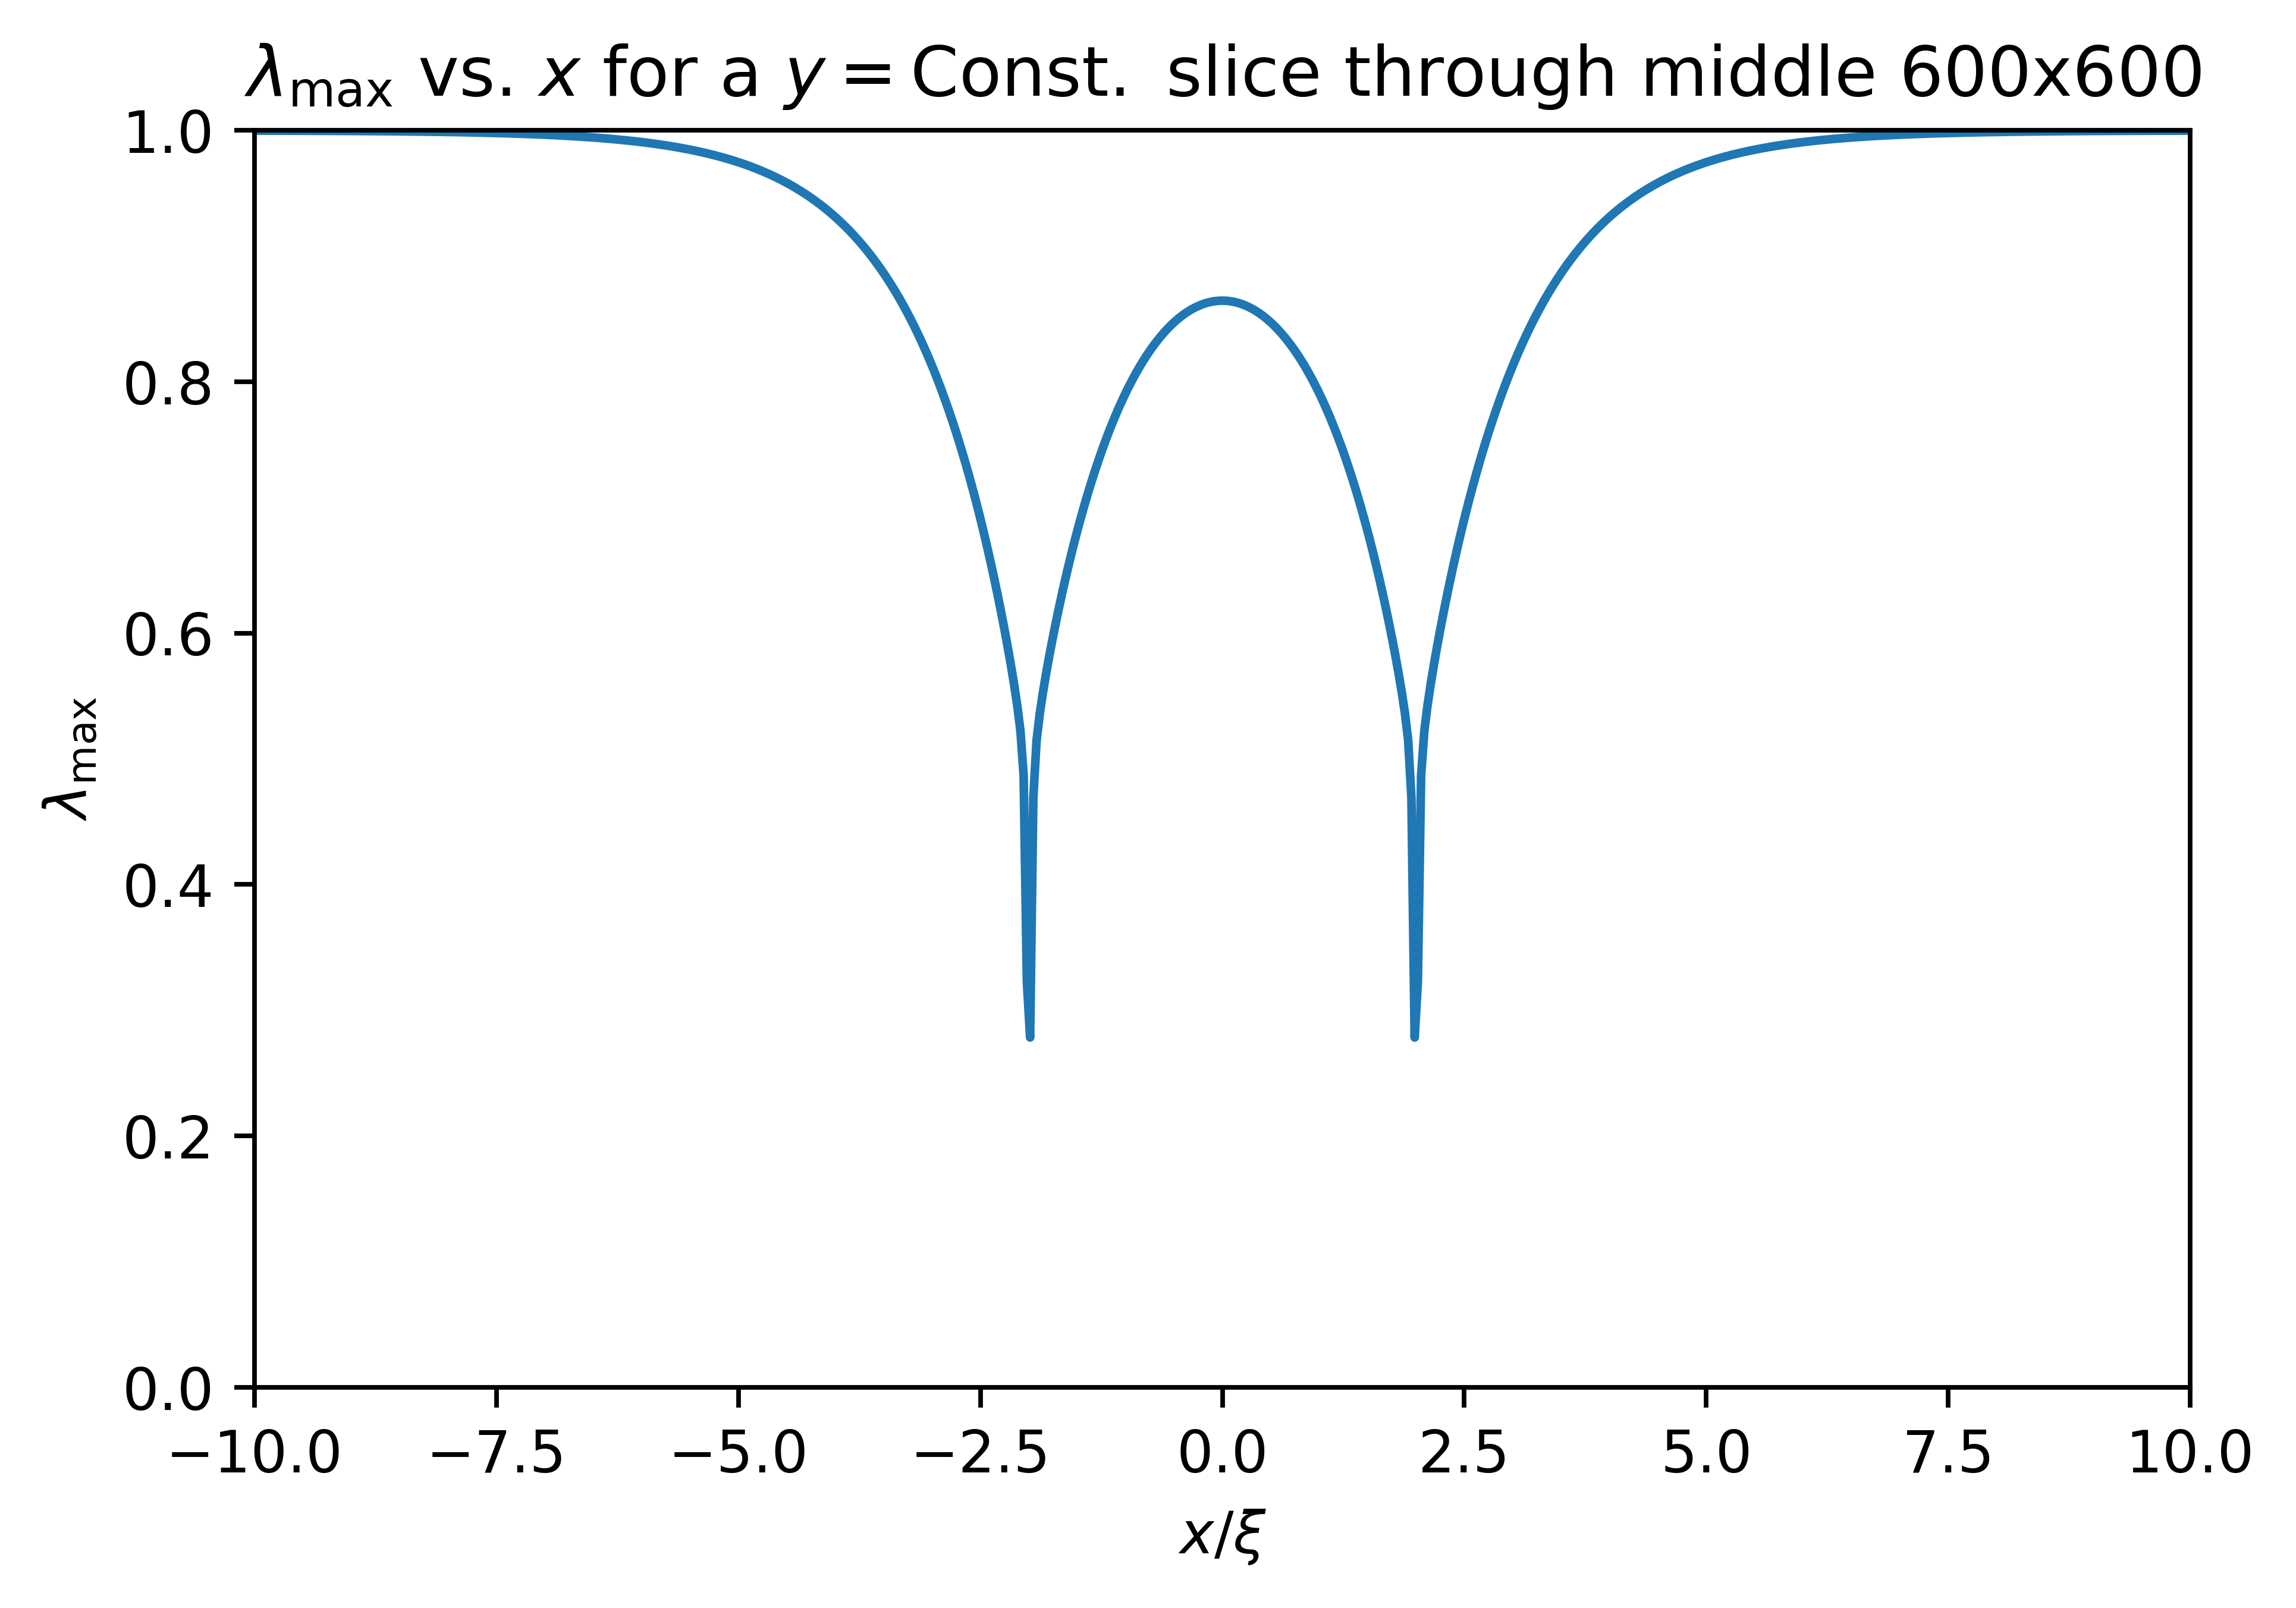

In [61]:
S_val = 1

fig, ax = plt.subplots()
xdata, ydata = X[:, middle], middle_slice[:, 0]
ln, = plt.plot(xdata, ydata)
plt.title(r"$\lambda_\mathrm{max}$ vs. $x$ for a $y = \mathrm{Const.}$ slice through middle 600x600")
plt.xlabel(r"$x/\xi$")
plt.ylabel(r"$\lambda_\mathrm{max}$")

def init(l=l, S_val=S_val):
    ax.set_xlim(-l, l)
    ax.set_ylim(0, S_val)
    return ln,

def update(frame, X=X, middle_slice=middle_slice, middle=middle):
    xdata = X[:, middle]
    ydata = middle_slice[:, frame]
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(0, 5000),
                    init_func=init, interval=2, blit=True)
plt.show()

In [62]:
ani_start_time = time.perf_counter()
filename_600pt_crosssection_animation = os.path.join(save_folder, r'two-disclination-600pt-crosssection.mp4')
ani.save(filename_600pt_crosssection_animation, dpi=200)
ani_end_time = time.perf_counter()

print("Time to save animation is", (ani_end_time - ani_start_time)/60, "minutes")

Time to save animation is 8.439795193333323 minutes


In [63]:
Video(filename_600pt_crosssection_animation, width=900)